# NARX Modelling
ARX models have endless varieties and flavors, but not all ARX models are linear models. Nonlinear ARX, or NARX, constitutes an important generalization of our traditional ARX models while allowing us to leverage tools from machine learning to produce more sophisticated nonlinear relationships. Thus, a NARX model will have the form 
$$
y(t+1) = F\left(\tilde{y}(t), \tilde{x}_1(t),\tilde{x}_P (t) , \varepsilon(t)\right) 
$$
where $F$ is some function, tilde denotes a time-lagged vector $\tilde{y}(t):=(y(t), y(t-1), ..., y(t-Q))$ and $\varepsilon(t)$ represents a random vector that can be included to model stochastic effects.

In [1]:
# Configuration
Ntt = 200 # Test-train split
enable_detrend = False 
enable_normalize=True
Q = 4 # Order of ARX Model

In [2]:
# Import libraries
import numpy as np
from numpy import genfromtxt
from numpy import linalg as lin
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn import linear_model
from sklearn import svm
from scipy.signal import savgol_filter
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
#from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel


# Import my own modules
import sys
sys.path.insert(0, '..')
from manifolds import embed
from signals import maimpute

# Import data
my_data = genfromtxt('../Data/natgas.data.csv', delimiter=',',dtype='f8')
my_data = my_data[1:,1:] # Ignore the first row, which contains headers
names = ["STOCKS","HDD_FORE","CDD_FORE","JFKTEMP","CLTTEMP","ORDTEMP","HOUTEMP","LAXTEMP","NXT_CNG_STK"]


# Delete the unused features
X = my_data[0:Ntt,:]
X = np.delete(X,1,axis=1)
X = np.delete(X,1,axis=1)
Xnames = ["STOCKS","JFKTEMP","CLTTEMP","ORDTEMP","HOUTEMP","LAXTEMP","NXT_CNG_STK"]

# Deseasonalize the data
window_length = 13
polyorder = 2
if enable_detrend:
    datatrend = savgol_filter(X[:,1:10], window_length, polyorder, axis=0)
    X[:,1:10] = X[:,1:10] - datatrend


# Delay embed all of our data. The last column will be our target
Z = np.empty((X.shape[0]-Q+1,Q*X.shape[1] ))
for k in range(0,X.shape[1]):
    Z[:,np.arange(0,Q) + k*Q] = embed(X[:,k],Q,1)
#Z[:,Q*X.shape[1] ] = np.mod(np.transpose(np.arange(0,Z.shape[0])),52)

# Separate target and predictors
y = Z[:,Z.shape[1]-1]  
Z = Z[:,0:Z.shape[1]-1]
#Z = np.delete(Z,Z.shape[1]-1,axis=1)

# Normalize the input predictors
if enable_normalize:
    Z = normalize(Z, axis=0)

# Initialize matrix of predictions
NoModels = 4 # No. of models that I will have
Yp = 0*np.empty((y.shape[0],NoModels))

## Linear Models
First, we produce some linear model predictions so that we have them for comparison. Like last time, we will consider OLS and some shrinkage estimators for the ARX(Q) models.

In [3]:
# Fit a linear model using ordinary least squares (OLS)
OLSmdl = np.linalg.lstsq(Z, y, rcond=None)
Yp[:,0] = Z @ OLSmdl[0] 

# Fit a LASSO model
LASSOmdl = linear_model.Lasso(alpha=0.5)
LASSOmdl.fit(Z, y)
Yp[:,1] = Z @ LASSOmdl.coef_

# Fit a LASSO model
ridgemdl = linear_model.Ridge(alpha=0.5)
ridgemdl.fit(Z, y)
Yp[:,2] = Z @ ridgemdl.coef_



## Gaussian Process NARX
To fit a nonlinear ARX model, I use Gaussian Process Regression (GPR) to fit a non-parametric function to the data set. This model should work well when there is a nonlinear dynamical component to the signal, and it provide uncertainty on its predictions naturally. This uncertainity could be useful in a data fusion setting. 

When fit to a single window, GPR can fit very well, but it is difficult to run a GPR method online within designing some custom software.

In [4]:
# Fit a GPR model to NARX
gpr = GaussianProcessRegressor().fit(Z, y)
Yp[:,3] = gpr.predict(Z)

## Gradient Boost NARX
XGBoost

## Plot in-sample fit
A

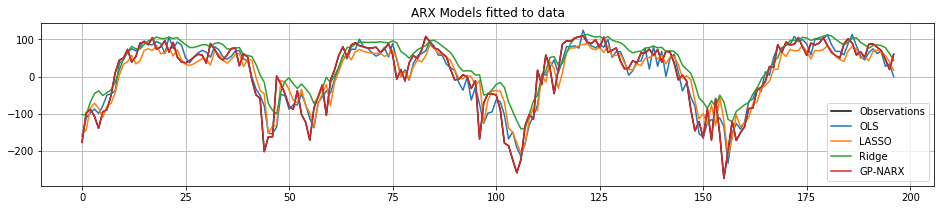

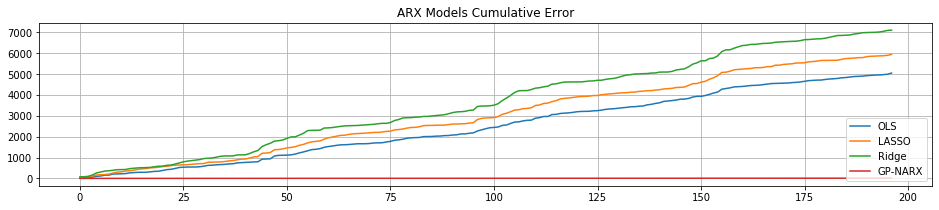

In [5]:
# Plot model fit
t = np.transpose(np.arange(0,y.shape[0]))
plt.figure(figsize=(16, 3))
plt.plot(t,y,'k-')
plt.plot(t,Yp)
plt.legend(['Observations','OLS','LASSO','Ridge','GP-NARX'], loc='lower right')
plt.title('ARX Models fitted to data')
plt.grid(True)
plt.show()


# Compute errors
Ype = 0*Yp
for k in range(0,Yp.shape[1]):
    Ype[:,k] = np.cumsum(np.abs(Yp[:,k]-y))    

# Plot Errors
plt.figure(figsize=(16, 3))
ax = plt.axes()
plt.plot(t,Ype)
plt.legend(['OLS','LASSO','Ridge','GP-NARX'], loc='lower right')
plt.title('ARX Models Cumulative Error')
plt.grid(True)
plt.show()

## Plot out-of-sample predictions
A

In [6]:
# Impute missing data
X2 = my_data[Ntt:,:]
X2 = maimpute(X2)
X2 = np.delete(X2,1,axis=1)
X2 = np.delete(X2,1,axis=1)

# Deseasonalize the data
if enable_detrend:
    datatrend2 = savgol_filter(X2[:,1:10], window_length, polyorder, axis=0)
    X2[:,1:10] = X2[:,1:10] - datatrend2


# Delay embed all of our data. The last column will be our target
Z2 = np.empty((X2.shape[0]-Q+1,Q*X2.shape[1]))
for k in range(0,X2.shape[1]):
    Z2[:,np.arange(0,Q) + k*Q] = embed(X2[:,k],Q,1)
#Z2[:,Q*X.shape[1] ] = np.mod(Ntt+np.transpose(np.arange(0,Z2.shape[0])),52)

# Remove separate target and predictors
y2 = Z2[:,Z2.shape[1]-1]  
Z2 = Z2[:,0:Z2.shape[1]-1]
#Z2 = np.delete(Z2,Z2.shape[1]-1,axis=1)

# Normalize the input predictors
if enable_normalize:
    Z2 = normalize(Z2, axis=0)

# Initialize matrix of predictions
Yp = 0*np.empty((y2.shape[0],NoModels))


C:\Users\kurtb\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\kurtb\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [7]:
# Make out of sample predictions
Yp[:,0] = Z2 @ OLSmdl[0]      # OLS   ARX
Yp[:,1] = Z2 @ LASSOmdl.coef_ # LASSO ARX
Yp[:,2] = Z2 @ ridgemdl.coef_ # Ridge ARX
Yp[:,3] = gpr.predict(Z2)     # GP    NARX


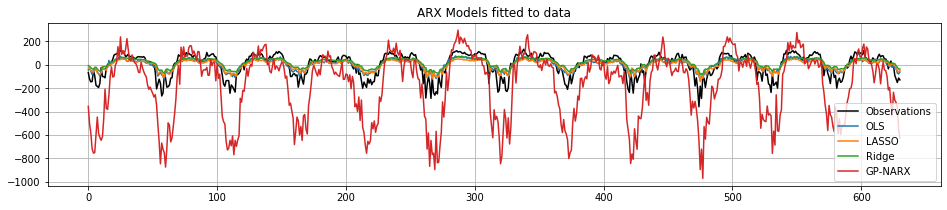

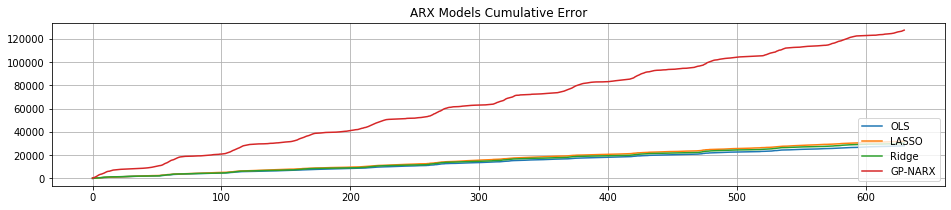

In [8]:
# Plot Predictions
t2 = np.transpose(np.arange(0,y2.shape[0]))
plt.figure(figsize=(16, 3))
plt.plot(t2,y2,'k-')
plt.plot(t2,Yp)
plt.legend(['Observations','OLS','LASSO','Ridge','GP-NARX'], loc='lower right')
plt.title('ARX Models fitted to data')
plt.grid(True)
plt.show()


# Compute errors
Ype = 0*Yp
for k in range(0,Yp.shape[1]):
    Ype[:,k] = np.cumsum(np.abs(Yp[:,k]-y2))    

# Plot Errors
plt.figure(figsize=(16, 3))
ax = plt.axes()
plt.plot(t2,Ype)
plt.legend(['OLS','LASSO','Ridge','GP-NARX'], loc='lower right')
plt.title('ARX Models Cumulative Error')
plt.grid(True)
plt.show()